<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#fasttext-models" data-toc-modified-id="fasttext-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>fasttext models</a></span></li><li><span><a href="#networks" data-toc-modified-id="networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>networks</a></span></li></ul></div>

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import numpy as np
import pandas as pd
import pickle

from gensim.models.fasttext import FastText
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Concatenate, Reshape, LSTM, GRU
from keras.optimizers import Adam
from keras.preprocessing.text import text_to_word_sequence

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
# !pip3.6 install pydot

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

# fasttext models

In [3]:
data_type = 'news'
df_chats_raw = pd.read_csv('../data/clean_{0}.csv'.format(data_type))

if not 'timestamp' in df_chats_raw.columns:
    df_chats_raw.rename(columns={'date':'timestamp'}, inplace=True)#.head()#['timestamp']

In [4]:
class SentenceIterator(object):
    texts = None

    def __init__(self, texts):
        self.texts = texts

    def __iter__(self):
        for text in self.texts:
            yield text_to_word_sequence(text, lower=False)

In [5]:
def build_fasttext(size=100):
    path = '../data/fasttext_{0}_{1}.pkl'.format(data_type, size)
    if os.path.exists(path):
        m = FastText.load(path)
    else:
        m = FastText(SentenceIterator(df_chats_raw['clean_text']), min_count=5, size=size, workers=-1)
        m.save(path)
    return m

In [6]:
def text2vec(text, m=None, size=None):
    vectors = []
    for word in text_to_word_sequence(text):
        try:
            v = m.wv[word]
            vectors.append(v)
        except Exception as e:
            pass
    if not vectors:
        return np.zeros((size, ))
    return sum(vectors) / len(vectors)

In [7]:
def build_vectors(texts, size=None):
    t_model = build_fasttext(size)
    vectors = list(map(lambda x: text2vec(x, m=t_model, size=size), texts))
    return np.array(vectors)

# networks

In [8]:
TICKER = 'ETH'

In [9]:
df_prices_raw = pd.read_csv('../data/train/tickers_train.csv', index_col=0)

In [10]:
df_prices_raw['timestamp'] = pd.to_datetime(df_prices_raw['datetime']).apply(lambda x: x.timestamp())

In [11]:
df_prices = df_prices_raw[df_prices_raw['ticker'] == TICKER].copy()

In [12]:
df_chats = df_chats_raw[df_chats_raw['clean_text'].str.contains(TICKER.lower())].copy()
print('df_chats.shape :', df_chats.shape)

df_chats.shape : (785, 11)


In [13]:
if 'chat_id' in df_chats.columns:
    chat_ids = list(df_chats['chat_id'].unique())
    chat_ids.sort()
    chat2ind = {chat_id: i for i, chat_id in enumerate(chat_ids)}
    df_chats['chat_ind'] = df_chats['chat_id'].apply(lambda x: chat2ind[x])
else:
    chat2ind = None

if 'sender_id' in df_chats.columns:
    sender_ids = list(df_chats['sender_id'].unique())
    sender_ids.sort()
    sender2ind = {sender_id: i for i, sender_id in enumerate(sender_ids)}
    df_chats['sender_ind'] = df_chats['sender_id'].apply(lambda x: sender2ind[x])
else:
    sender2ind = None

In [14]:
df_chats['ind'] = list(range(df_chats.shape[0]))

In [15]:
vectors100 = build_vectors(df_chats['clean_text'], size=100)

In [16]:
vectors160 = build_vectors(df_chats['clean_text'], size=160)

In [17]:
vectors60 = build_vectors(df_chats['clean_text'], size=60)

In [18]:
def build_dataset(samples=5, steps=32, vectors=None):
    
    target_min_up=1.1
    target_max_down=0.95
    hours_before=48
    hours_after=48
    
    np.random.seed(0)
    
    inp_fasttext = []
    inp_chat_ind = []
    inp_sender_ind = []
    inp_timedelta_log = []
    out_target = [] # grow more than 0.66 quantile, not drawdown less 0.33 quantile in period 48 hours
    
    for i, row in df_prices.iterrows():
        ts = row['timestamp']
        if df_chats[
                (df_chats['timestamp'] > ts - hours_before * 3600) & 
                (df_chats['timestamp'] < ts)].shape[0] == 0:
            continue

        for sample in range(samples):
            ts = row['timestamp']

#             print(ts - hours_before * 3600, ts, hours_before)
            df_chats_sample = df_chats[
                (df_chats['timestamp'] > ts - hours_before * 3600) & 
                (df_chats['timestamp'] < ts)].sample(steps, replace=True)
            df_chats_sample['timedelta'] = np.log(-(df_chats_sample['timestamp'] - ts))

            chat_indexes = df_chats_sample['ind'].values

            batch_fasttext = vectors[chat_indexes]
            batch_timedelta = df_chats_sample['timedelta'].values

            if not chat2ind is None:
                batch_chat_ind = df_chats.iloc[chat_indexes]['chat_ind'].values
                inp_chat_ind.append(batch_chat_ind)

            if not sender2ind is None:
                batch_sender_ind = df_chats.iloc[chat_indexes]['sender_ind'].values
                inp_sender_ind.append(batch_sender_ind)

            df_prices_forward = df_prices[
                (df_prices['timestamp'] > ts) & 
                (df_prices['timestamp'] <= ts + hours_after * 3600)].copy()
            df_prices_forward = df_prices_forward.sort_values('timestamp')

            if df_prices_forward.shape[0] < int(hours_after / 2):
                continue
            df_prices_forward['priceUsd'] /= df_prices_forward['priceUsd'].values[0]

            target = False
            for price_relative in df_prices_forward['priceUsd'].values:
                if price_relative < target_max_down:
                    target = False
                    break
                if price_relative > target_min_up:
                    target = True
                    break

            inp_fasttext.append(batch_fasttext)
#             inp_chat_ind.append(batch_chat_ind)
#             inp_sender_ind.append(batch_sender_ind)
            inp_timedelta_log.append(batch_timedelta)
            out_target.append(target)
    
    inp_fasttext = np.array(inp_fasttext)
    inp_chat_ind = np.array(inp_chat_ind)
    inp_sender_ind = np.array(inp_sender_ind)
    inp_timedelta_log = np.array(inp_timedelta_log)

    out_target = np.array(out_target)
    
    inp_chat_ind = np.expand_dims(inp_chat_ind, 2)
    inp_sender_ind = np.expand_dims(inp_sender_ind, 2)
    inp_timedelta_log = np.expand_dims(inp_timedelta_log, 2)

    test_size = int(inp_fasttext.shape[0] * 0.1)
    
    X_train = [inp_fasttext[:-test_size]]\
        + ([] if chat2ind is None else inp_chat_ind[:-test_size])\
        + ([] if sender2ind is None else inp_sender_ind[:-test_size])\
        + [inp_timedelta_log[:-test_size]]

    Y_train = out_target[:-test_size]
    validation_data=[

        [inp_fasttext[-test_size:]]
        + ([] if chat2ind is None else inp_chat_ind[-test_size:])\
        + ([] if sender2ind is None else inp_sender_ind[-test_size:])\
        + [inp_timedelta_log[-test_size:]],

        out_target[-test_size:]

    ]
    
    return X_train, Y_train, validation_data

# X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors100)
# # # 1519689600.0 1519862400.0 48
# ts = 1519862400.0
# hours_before = 48
# steps=32
# # df_chats[(df_chats['timestamp'] > ts - hours_before * 3600) &
# #     (df_chats['timestamp'] < ts)].sample(steps, replace=True)
# # df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))
# print(df.head())
# print(df.sample(n=2, replace=True))
# print(df.head())

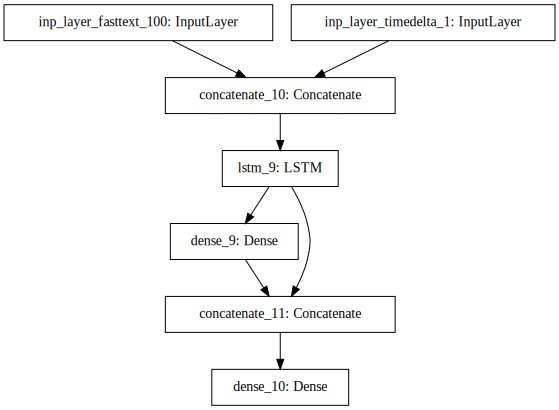

In [41]:
def build_nn(sender_size=128, chat_size=4, STEPS=None, lr=0.0001, fasttext_size=100):

    SENDER_EMBEDDING_SIZE = sender_size
    CHAT_EMBEDDING_SIZE = chat_size

    inp_layer_fasttext = Input(shape=(STEPS, fasttext_size, ), name='inp_layer_fasttext_{0}'.format(fasttext_size))
    # inp_layer_sender_bot = Input(shape=(STEPS, 1, ), name='inp_layer_sender_bot')

    inp_layer_timedelta = Input(shape=(STEPS, 1, ), name='inp_layer_timedelta_{0}'.format(1))

    common_layer = Concatenate(axis=-1)([
        inp_layer_fasttext, inp_layer_timedelta])

    if not chat2ind is None:
        inp_layer_chat = Input(shape=(STEPS, 1, ), name='inp_layer_chat')
        chat_embedding = Embedding(len(chat2ind), CHAT_EMBEDDING_SIZE)(inp_layer_chat)
        chat_embedding = Reshape((STEPS, CHAT_EMBEDDING_SIZE))(chat_embedding)
        common_layer = Concatenate(axis=-1)([common_layer, chat_embedding])

    if not sender2ind is None:
        inp_layer_sender = Input(shape=(STEPS, 1, ), name='inp_layer_sender')
        sender_embedding = Embedding(len(sender2ind), SENDER_EMBEDDING_SIZE)(inp_layer_sender)
        sender_embedding = Reshape((STEPS, SENDER_EMBEDDING_SIZE))(sender_embedding)
        common_layer = Concatenate(axis=-1)([common_layer, sender_embedding])
        
#     common_layer = Concatenate(axis=-1)([
#         inp_layer_fasttext, chat_embedding, sender_embedding, inp_layer_timedelta])
    
#     lstm = LSTM(8)(common_layer)
#     # lstm = LSTM(8)(lstm)

    lstm_in = LSTM(32)(common_layer)
    # lstm = LSTM(8)(lstm)

    dense_0 = Dense(16, activation='relu')(lstm_in)
    common_layer_out = Concatenate(axis=-1)([lstm_in, dense_0])

#     lstm_0 = Conv2D((3.3))(lstm_in)
#     common_layer_out = Concatenate(axis=-1)([lstm_in, dense_0])
    
    dense_out = Dense(1, activation='sigmoid')(common_layer_out)

    model = Model( inputs=[inp_layer_fasttext, inp_layer_timedelta]
                            + [] if chat2ind is None else [inp_layer_chat]
                            + [] if sender2ind is None else [inp_layer_sender]
                    , outputs=dense_out
                )

    opt = Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
# from keras.layers import Conv2D

# model.compile(optimizer='sgd', loss='binary_crossentropy')
model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=100)
# plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

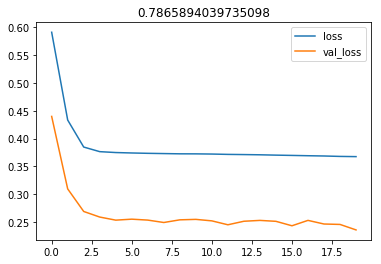

In [43]:
def model_report(model, val1):
    y_pred = model.predict(val1[0])
    model_roc_auc_score = roc_auc_score(val1[1], y_pred)
    # print('roc_auc = {0}'.format(model_roc_auc_score))

    plt.plot(model.history.history['loss'], label='loss')
    plt.plot(model.history.history['val_loss'], label='val_loss')
    plt.title(model_roc_auc_score)
    plt.legend()
    plt.show()
model_report(model, val1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


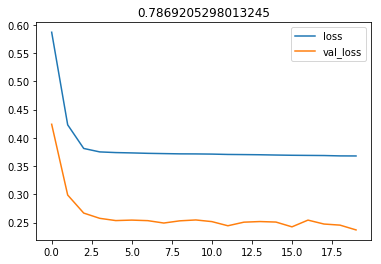

CPU times: user 1min 22s, sys: 14.2 s, total: 1min 36s
Wall time: 27.1 s


In [44]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors160)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

model_report(model, val1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


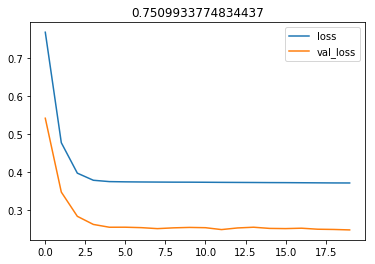

CPU times: user 1min 31s, sys: 15.1 s, total: 1min 46s
Wall time: 28.3 s


In [45]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=260)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors160], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

model_report(model, val1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


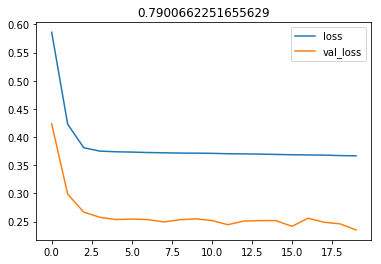

CPU times: user 1min 22s, sys: 14.5 s, total: 1min 37s
Wall time: 27.7 s


In [46]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors60], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

model_report(model, val1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


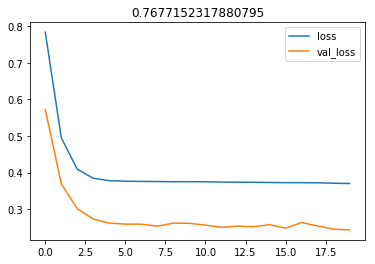

CPU times: user 1min 13s, sys: 13.6 s, total: 1min 27s
Wall time: 26.5 s


In [47]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=60)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors60)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

model_report(model, val1)

In [48]:
with open('../data/train_test_{0}_U.pkl'.format(data_type), 'wb') as f:
    f.write(pickle.dumps({
        'x': X1,
        'y': Y1,
        'validation': val1,
    }))

# tune hyperparams

In [59]:
space = {
#     'sender_size': hp.choice('sender_size', list(range(8, 256))),
#     'chat_size': hp.choice('chat_size', list(range(2, 10))),
    'sender_size': hp.choice('sender_size', [0]),
    'chat_size': hp.choice('chat_size', [0]),
    'steps': hp.choice('steps', [32, 64, 128]),
    'lr': 10**hp.uniform('lr', -8, -2),
    'samples': hp.choice('samples', list(range(1, 10))),
}

In [60]:
x = hyperopt.pyll.stochastic.sample(space)

In [61]:
x

{'chat_size': 0,
 'lr': 5.353573095591712e-06,
 'samples': 1,
 'sender_size': 0,
 'steps': 32}

In [62]:
del x

In [63]:
def objective(x):
    
    np.random.seed(0)
    
    print(x)
    
    model = build_nn(
        sender_size=x['sender_size'], chat_size=x['chat_size'], STEPS=x['steps'], 
        lr=x['lr'], fasttext_size=100)
    X1, Y1, val1 = build_dataset(samples=x['samples'], steps=x['steps'], vectors=vectors100)
    model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)
    
    y_pred = model.predict(val1[0])
    score = roc_auc_score(val1[1], y_pred)
    
    print('roc_auc', score)
    
    return {'loss': -score, 'status': STATUS_OK}

In [66]:
trials = Trials()

In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

{'chat_size': 0, 'lr': 2.5389651409503606e-08, 'samples': 2, 'sender_size': 0, 'steps': 32}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


roc_auc 0.3416666666666667
{'chat_size': 0, 'lr': 0.0009845138599772058, 'samples': 3, 'sender_size': 0, 'steps': 64}
roc_auc 0.6781767955801105
{'chat_size': 0, 'lr': 0.00024484575874470416, 'samples': 5, 'sender_size': 0, 'steps': 64}
roc_auc 0.8539735099337749
{'chat_size': 0, 'lr': 5.32843823246512e-05, 'samples': 9, 'sender_size': 0, 'steps': 32}
roc_auc 0.7936873337425824
{'chat_size': 0, 'lr': 1.1025332574673645e-07, 'samples': 7, 'sender_size': 0, 'steps': 32}
roc_auc 0.3990352064996614
{'chat_size': 0, 'lr': 1.61992213641183e-06, 'samples': 5, 'sender_size': 0, 'steps': 64}
roc_auc 0.29619205298013246
{'chat_size': 0, 'lr': 0.0018025173586739141, 'samples': 5, 'sender_size': 0, 'steps': 32}
roc_auc 0.7582781456953642
{'chat_size': 0, 'lr': 0.002414996479563641, 'samples': 1, 'sender_size': 0, 'steps': 128}
roc_auc 0.6791666666666667
{'chat_size': 0, 'lr': 6.268296093751154e-05, 'samples': 2, 'sender_size': 0, 'steps': 64}
roc_auc 0.7416666666666666
{'chat_size': 0, 'lr': 6.261

In [ ]:
best

In [ ]:
{'chat_size': 5, 'lr': 0.000033215565785761354, 'samples': 5, 'sender_size': 213, 'steps': 128}
# roc_auc 0.7789987789987789

In [ ]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=213, chat_size=5, STEPS=128, lr=0.00003, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=128, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
score = roc_auc_score(val1[1], y_pred)

print('roc auc', score)

In [ ]:
fpr, tpr, thresholds = roc_curve(val1[1], y_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()

In [ ]:
X2, Y2, val2 = build_dataset(samples=1, steps=128, vectors=vectors100)
y2_pred = model.predict(val2[0])[:, 0]

In [ ]:
for fp, tp, th in zip(fpr, tpr, thresholds):
    if tp > 0.6:
        print(th)
        break

In [ ]:
(y2_pred > th).astype(np.int).shape

In [ ]:
(y2_pred > th).astype(np.int)

In [ ]:
model.save('../data/model_{0}_eth.pkl'.format(data_type))

# visualizations

In [ ]:
e = model.layers[3]

In [ ]:
weights = e.get_weights()[0]

In [ ]:
weights.shape

In [ ]:
tsne = TSNE()

In [ ]:
%%time
weights_tsne = tsne.fit_transform(weights)

In [ ]:
plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], alpha=0.05)
plt.show()

In [ ]:
d = pd.DataFrame(weights_tsne, columns=['x', 'y'])

In [ ]:
d['index'] = list(range(d.shape[0]))

In [ ]:
center1 = [-10, 0]
center2 = [-20, 40]

In [ ]:
d1 = []
d2 = []
for i, row in d.iterrows():
    d1.append((center1[0] - row['x']) ** 2 + (center1[1] - row['y']) ** 2)
    d2.append((center2[0] - row['x']) ** 2 + (center2[1] - row['y']) ** 2)
    
d['d1'] = d1
d['d2'] = d2

In [ ]:
d.sort_values('d1')[:5]

In [ ]:
d.sort_values('d2')[:5]

In [ ]:
df_chats[df_chats['sender_ind'].isin(d.sort_values('d1')[:5]['index'])]['text'].values

In [ ]:
df_chats[df_chats['sender_ind'].isin(d.sort_values('d2')[:5]['index'])]['text'].values

In [ ]:
prices = df_prices['priceUsd'].pct_change()[1:].values

In [ ]:
plt.hist(prices, bins=20)
plt.show()

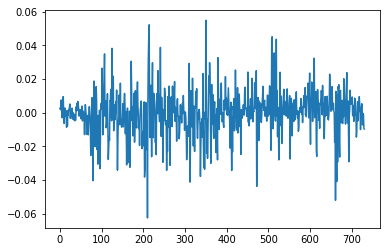

In [134]:
plt.plot(prices)

In [138]:
adfuller(prices)

(-8.535428772025405,
 1.0110438004829059e-13,
 6,
 724,
 {'1%': -3.4394144152232995,
  '5%': -2.8655403100177566,
  '10%': -2.5689002207655443},
 -4169.700082124158)

In [246]:
val1[-1].shape

(322,)